# Install missing required packages


In [ ]:
# Install pybullet
!pip install pybullet
# Install numpngw -- For visualization purposes
!pip install numpngw
!pip install control

: 

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numpngw import write_apng
from IPython.display import Image
from tqdm.notebook import tqdm

# Cartpole Setup

In [2]:
from cartpole_env import *

pybullet build time: Apr 16 2023 15:25:47


  0%|          | 0/100 [00:00<?, ?it/s]

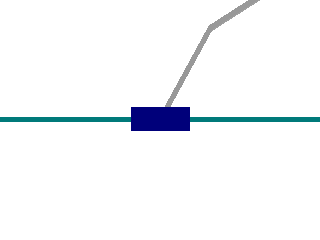

In [5]:
env = CartpoleEnv()
env.reset(state = np.array([0.0, 0.5, 0.5, 0.0, 0.0, 0.0]))

frames=[] #frames to create animated png
frames.append(env.render())
for i in tqdm(range(100)):
    action = env.action_space.sample()
    s = env.step(action)
    img = env.render()
    frames.append(img)

write_apng("cartpole_example.png", frames, delay=10)
Image(filename="cartpole_example.png")

# dynamics analytic


In [ ]:
def dynamics_analytic(state, action):
    """
        Computes x_t+1 = f(x_t, u_t) using analytic model of dynamics in Pytorch
        Should support batching
    Args:
        state: torch.tensor of shape (B, 4) representing the cartpole state
        control: torch.tensor of shape (B, 1) representing the force to apply

    Returns:
        next_state: torch.tensor of shape (B, 4) representing the next cartpole state

    """
    next_state = None
    dt = 0.05
    g = 9.81
    mc = 1
    mp = 0.1
    l = 0.5

    # --- Your code here
    mt = mp + mc
    # state
    x, theta, dx, dtheta = torch.chunk(state, 4, 1)
    # print(x, theta, dx, dtheta)
    st = torch.sin(theta)
    ct = torch.cos(theta)

    # Compute accelerations
    tacc = (g * st - ct * (action + mp * l * dtheta ** 2 * st) / mt) / (l * ((4.0 / 3.0) - ((mp * ct ** 2) / mt)))
    xacc = (action + mp * l * (dtheta ** 2 * st - tacc * ct)) / mt

    #### be careful the order

    # Update velocities.
    dx = dx + xacc * dt
    dtheta = dtheta + tacc * dt

    # Update position/angle.
    x = x + dt * dx
    theta = theta + dt * dtheta



    next_state = torch.cat([x, theta, dx, dtheta], dim = 1)
    # ---

    return next_state


def linearize_pytorch(state, control):
    """
        Linearizes cartpole dynamics around linearization point (state, control). Uses autograd of analytic dynamics
    Args:
        state: torch.tensor of shape (4,) representing cartpole state
        control: torch.tensor of shape (1,) representing the force to apply

    Returns:
        A: torch.tensor of shape (4, 4) representing Jacobian df/dx for dynamics f
        B: torch.tensor of shape (4, 1) representing Jacobian df/du for dynamics f

    """
    A, B = None, None
    # --- Your code here
    state = torch.reshape(state, (1, 4))
    control = torch.reshape(control, (1, 1))
    A, B = jacobian(dynamics_analytic,(state,control))
    A, B = A[0, :, 0, :], B[0, :, 0, :]
    # ---
    return A, B

# Optimization
implement one of the following
algorithms:

ROB 498 Final Project 2

a. iLQR (https://homes.cs.washington.edu/~todorov/papers/TassaIROS12.pdf)

b. DDP: https://arc.aiaa.org/doi/abs/10.2514/6.2022-0624
i. You can get access to this article with your umich id. The easiest way is to
download it when connected to university WiFi

c. SQP (https://optimization.cbe.cornell.edu/index.php?
title=Sequential_quadratic_programming)
i. the choice of whether to use shooting or collocation for this problem is up to you.
All of these methods use a quadratic approximation of the cost function. You will need to construct an appropriate cost function for the inverted double-pendulum on a cart. Your experiments should compare the performance of the algorithm you implemented to MPPI on several starting configurations.

# Compare to MPPI or other method
